In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo.gates import M, X, RY, CZ, I, H
from qibo.models import Circuit
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from benchmarks.utils.qst_qpt_helper_functions import process_returned_dataformat

from itertools import product

api = API(ConnectionConfiguration(username="qat", api_key="meow"))


api.select_device_id(9)

In [37]:
def get_chsh_circuits(bell_state, control_qubit, target_qubit, theta):
    assert bell_state in (
        "phi_plus",
        "phi_minus",
        "psi_plus",
        "psi_minus",
    ), "bell_state should be phi_plus, phi_minus, psi_plus, psi_minus"
    nqubits = max(control_qubit, target_qubit) + 1

    circuits = []
    for gate_a, gate_b in product([I, H], repeat=2):
        circuit = Circuit(nqubits)

        if bell_state == "phi_plus" or bell_state == "psi_minus":
            G1 = RY(control_qubit, theta=-np.pi / 2)
        else:
            G1 = RY(control_qubit, theta=np.pi / 2)
        if bell_state == "phi_plus" or bell_state == "phi_minus":
            G2_prime = RY(target_qubit, theta=-np.pi / 2)
        else:
            G2_prime = RY(target_qubit, theta=np.pi / 2)
        ## build bell state
        circuit.add(G1)
        circuit.add(RY(target_qubit, theta=np.pi / 2))
        circuit.add(CZ(control_qubit, target_qubit))
        circuit.add(G2_prime)

        ## decoder part
        circuit.add(RY(control_qubit, theta=theta))
        circuit.add(gate_a(control_qubit))
        circuit.add(gate_b(target_qubit))
        circuit.add(M(control_qubit, target_qubit))

        circuits.append(circuit)

    return circuits


def RO_fidelity_circuits(control_qubit, target_qubit):
    """Circuits to get the SPAM matrix in order to perform measurement correction."""
    RO_circuits = []

    for qb in [control_qubit, target_qubit]:
        for g in [I, X]:
            circuit = Circuit(5)
            circuit.add(g(qb))
            circuit.add(M(qb))
            RO_circuits.append(circuit)

    return RO_circuits


def compute_witnesses(chsh_results, measurement_calibration_weights, BELL_STATE, raw=False):
    """Returns arrays of computed witness values.

    Args:
        chsh_results (array): matrix containing the probabilities the chsh circuits. It must be
                        of dimensions len(theta_values) x 4 (decoder circuits) x 4 (probabilities)
        measurement_calibration_weights (array): measurement calibration matrix.
        BELL_STATE (string): can be "phi_plus", "phi_minus", "psi_plus" or "psi_minus". It needs
                            to be specified because the witness isn't the same for all 4 Bell states.
        raw (bool): whether or not calculate the witnesses from the raw data instead of applying the
                    measurement corrections. Defaults to False.
    Returns:
        witness1 (array): array length len(theta_values) containing the first witness
        witness2 (array): array length len(theta_values) containing the second witness
    """
    len_theta_values = np.shape(chsh_results)[0]
    witness1 = np.zeros(len_theta_values)
    witness2 = np.zeros(len_theta_values)

    if BELL_STATE == "phi_plus" or BELL_STATE == "psi_minus":
        signs1 = np.array([1, 1, -1, 1])
        signs2 = np.array([1, -1, 1, 1])
    else:
        signs1 = np.array([-1, 1, 1, 1])
        signs2 = np.array([1, 1, 1, -1])

    for i, chsh_result in enumerate(chsh_results):
        if raw != True:
            # apply measurement calibration
            chsh_result = measurement_calibration_weights @ chsh_result.T
            # calculate expectation values from probabilities
            expectations = np.array([1, -1, -1, 1]).T @ chsh_result

        else:
            # calculate expectation values from probabilities
            expectations = chsh_result @ np.array([1, -1, -1, 1])
        # compute witnesses
        witness1[i] = signs1.T @ expectations
        witness2[i] = signs2.T @ expectations
    return witness1, witness2


def get_RO_fidelity_matrix(RO_fid_q0, RO_fid_q1):
    r0, r1 = RO_fid_q0, RO_fid_q1
    w0, w1 = 1 - RO_fid_q0, 1 - RO_fid_q1
    mat = np.array(
        [
            [r0 * r1, r0 * w1, w0 * r1, w0 * w1],
            [r0 * w1, r0 * r1, w0 * w1, w0 * r1],
            [w0 * r1, w0 * w1, r0 * r1, r0 * w1],
            [w0 * w1, w0 * r1, r0 * w1, r0 * r1],
        ]
    )
    return mat

In [33]:
CONTROL_QUBIT = 2
TARGET_QUBIT = 0
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "psi_minus"

NUM_SHOTS = 8000

### Build circuits for CHSH and measurement correction

In [34]:
all_circuits_chsh = []
for theta in THETA_VALUES:
    circuits_th = get_chsh_circuits(BELL_STATE, CONTROL_QUBIT, TARGET_QUBIT, theta)
    all_circuits_chsh.extend(circuits_th)

all_circuits = RO_fidelity_circuits(CONTROL_QUBIT, TARGET_QUBIT)

all_circuits.extend(all_circuits_chsh)

### Run circuits

In [35]:
result_id = api.execute(all_circuits, nshots=NUM_SHOTS)[0]

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1709719055, time: 1709720022(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/circuits"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1709719055, time: 1709720022(leeway: 60)"}



### Process real data

In [36]:
results = api.get_result(result_id)

Your job with id 9611 is still pending. Job queue position: 3


In [9]:
data_probabilities_R0 = process_returned_dataformat(results[:4], nqubits=1)
data_probabilities_chsh = process_returned_dataformat(results[4:], nqubits=2)

In [39]:
## retrieve data
results = api.get_result(result_id)
data_probabilities_R0 = process_returned_dataformat(results[:4], nqubits=1)
data_probabilities_chsh = process_returned_dataformat(results[4:], nqubits=2)

## measurement calibration data processing
RO_fid_avg = []
for idx in range(2):
    c_I = data_probabilities_R0[idx * 2]
    c_X = data_probabilities_R0[idx * 2 + 1]
    clf_0 = (1 - c_I[0] + c_I[1]) / 2
    clf_1 = (1 - c_X[0] + c_X[1]) / 2
    fid_avg = (1 - clf_0 + clf_1) / 2
    RO_fid_avg.append(fid_avg)
RO_fidelity_matrix = get_RO_fidelity_matrix(*RO_fid_avg)
print(*RO_fid_avg)
print(RO_fidelity_matrix)

measurement_calibration_weights = np.linalg.inv(RO_fidelity_matrix)

## chsh circuits data processing
chsh_data_probabilities_theta = data_probabilities_chsh.reshape(len(THETA_VALUES), 4, 4)

## compute witness
w1_raw, w2_raw = compute_witnesses(chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=True)
w1_corrected, w2_corrected = compute_witnesses(
    chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=False
)

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1709720323, time: 1709720385(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/jobs/9611"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1709720323, time: 1709720385(leeway: 60)"}

Your job with id 9611 is completed.


0.8532500000000001 0.8853125
[[0.75539289 0.09785711 0.12991961 0.01683039]
 [0.09785711 0.75539289 0.01683039 0.12991961]
 [0.12991961 0.01683039 0.75539289 0.09785711]
 [0.01683039 0.12991961 0.09785711 0.75539289]]


### Run simulation, get ideal witnesses

In [40]:
# circ_list = RO_fidelity_circuits(0, 1)
# ideal_results_spam = np.zeros((len(circ_list), 4))
# for i, c in enumerate(circ_list):
#     ideal_results_spam[i] += c.execute().probabilities()
ideal_measurement_calibration_weights = np.eye(4)

circ_list = list(np.copy(all_circuits_chsh))
ideal_results_chsh = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_chsh[i] += c.execute().probabilities()

ideal_results_chsh_theta = ideal_results_chsh.reshape(len(THETA_VALUES), 4, 4)

w1_ideal, w2_ideal = compute_witnesses(
    ideal_results_chsh_theta, ideal_measurement_calibration_weights, BELL_STATE, raw=False
)

### Plot results

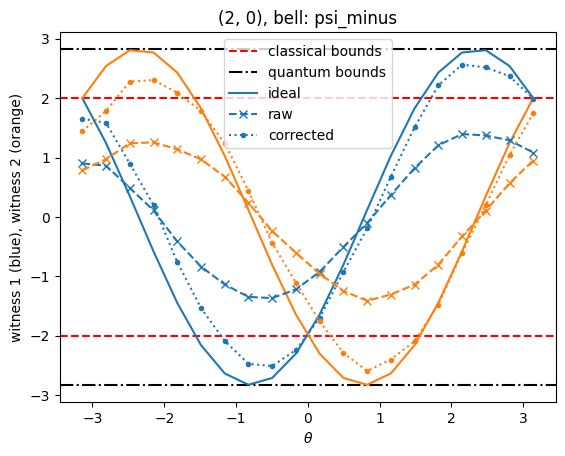

In [41]:
fname = f"chsh_{CONTROL_QUBIT}_{TARGET_QUBIT}_{BELL_STATE}_nshots{NUM_SHOTS}_jobid{result_id}.png"
savefig = False

fig, ax = plt.subplots()
ax.axhline(2, color="red", linestyle="--", label="classical bounds")
ax.axhline(-2, color="red", linestyle="--")
ax.axhline(2 * np.sqrt(2), color="k", linestyle="-.", label="quantum bounds")
ax.axhline(-2 * np.sqrt(2), color="k", linestyle="-.")

ax.plot(THETA_VALUES, w1_ideal, label="ideal")
ax.plot(THETA_VALUES, w2_ideal)

ax.plot(THETA_VALUES, w1_raw, "x--", c="C0", label="raw")
ax.plot(THETA_VALUES, w2_raw, "x--", c="C1")

ax.plot(THETA_VALUES, w1_corrected, "o:", ms=3, c="C0", label="corrected")
ax.plot(THETA_VALUES, w2_corrected, "o:", ms=3, c="C1")
ax.legend()

ax.set_xlabel("$\\theta$")
ax.set_ylabel("witness 1 (blue), witness 2 (orange)")

ax.set_title(f"({CONTROL_QUBIT}, {TARGET_QUBIT}), bell: {BELL_STATE}")
if savefig:
    fig.savefig(fname, bbox_inches="tight")